In [11]:
import numpy as np
from scipy.optimize import minimize, Bounds
import time
from utils import create_robot, create_obstacles, plot_robot_and_obstacles

In [2]:
SIM_TIME = 8. 
TIMESTEP = 0.1
NUMBER_OF_TIMESTEPS = int(SIM_TIME/TIMESTEP)
ROBOT_RADIUS = 0.5
VMAX = 2
VMIN = 0.2

# collision cost parameters
Qc = 5.
kappa = 4.

In [3]:
# nmpc parameters
HORIZON_LENGTH = int(4)
NMPC_TIMESTEP = 0.3
upper_bound = [(1/np.sqrt(2)) * VMAX] * HORIZON_LENGTH * 2
lower_bound = [-(1/np.sqrt(2)) * VMAX] * HORIZON_LENGTH * 2

In [4]:
def compute_xref(start, goal, number_of_steps, timestep):
    dir_vec = (goal - start)
    norm = np.linalg.norm(dir_vec)
    if norm < 0.1:
        new_goal = start
    else:
        dir_vec = dir_vec / norm
        new_goal = start + dir_vec * VMAX * timestep * number_of_steps
    return np.linspace(start, new_goal, number_of_steps).reshape((2*number_of_steps))

In [5]:
def update_state(x0, u, timestep):
    """
    Computes the states of the system after applying a sequence of control signals u on
    initial state x0
    """
    N = int(len(u) / 2)
    lower_triangular_ones_matrix = np.tril(np.ones((N, N)))
    kron = np.kron(lower_triangular_ones_matrix, np.eye(2))

    new_state = np.vstack([np.eye(2)] * int(N)) @ x0 + kron @ u * timestep

    return new_state

In [6]:
def collision_cost(x0, x1):
    """
    Cost of collision between two robot_state
    """
    d = np.linalg.norm(x0 - x1)
    cost = Qc / (1 + np.exp(kappa * (d - 2*ROBOT_RADIUS)))
    return cost

In [7]:
def total_cost(u, robot_state, obstacle_predictions, xref):
    x_robot = update_state(robot_state, u, NMPC_TIMESTEP)
    c1 = tracking_cost(x_robot, xref)
    c2 = total_collision_cost(x_robot, obstacle_predictions)
    total = c1 + c2
    return total


def tracking_cost(x, xref):
    return np.linalg.norm(x-xref)


def total_collision_cost(robot, obstacles):
    total_cost = 0
    for i in range(HORIZON_LENGTH):
        for j in range(len(obstacles)):
            obstacle = obstacles[j]
            rob = robot[2 * i: 2 * i + 2]
            obs = obstacle[2 * i: 2 * i + 2]
            total_cost += collision_cost(rob, obs)
    return total_cost


In [8]:
def compute_velocity(robot_state, obstacle_predictions, xref):
    """
    Computes control velocity of the copter
    """
    # u0 = np.array([0] * 2 * HORIZON_LENGTH)
    u0 = np.random.rand(2*HORIZON_LENGTH)
    def cost_fn(u): return total_cost(
        u, robot_state, obstacle_predictions, xref)

    bounds = Bounds(lower_bound, upper_bound)

    res = minimize(cost_fn, u0, method='SLSQP', bounds=bounds)
    velocity = res.x[:2]
    return velocity, res.x


In [9]:
def predict_obstacle_positions(obstacles):
    obstacle_predictions = []
    for i in range(np.shape(obstacles)[1]):
        obstacle = obstacles[:, i]
        obstacle_position = obstacle[:2]
        obstacle_vel = obstacle[2:]
        u = np.vstack([np.eye(2)] * HORIZON_LENGTH) @ obstacle_vel
        obstacle_prediction = update_state(obstacle_position, u, NMPC_TIMESTEP)
        obstacle_predictions.append(obstacle_prediction)
    return obstacle_predictions

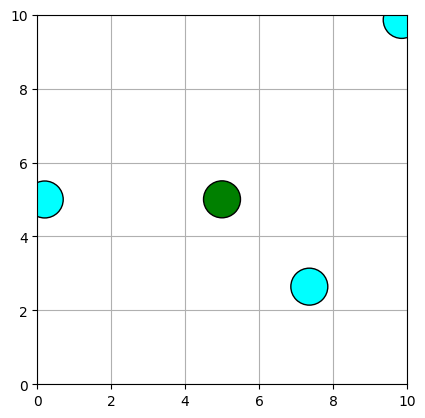

In [16]:
filename = "nmpc.avi"
obstacles = create_obstacles(SIM_TIME, NUMBER_OF_TIMESTEPS)

start = np.array([5, 5])
p_desired = np.array([5, 5])

robot_state = start
robot_state_history = np.empty((4, NUMBER_OF_TIMESTEPS))

for i in range(NUMBER_OF_TIMESTEPS):
    # predict the obstacles' position in future
    obstacle_predictions = predict_obstacle_positions(obstacles[:, i, :])
    xref = compute_xref(robot_state, p_desired,
                        HORIZON_LENGTH, NMPC_TIMESTEP)
    # compute velocity using nmpc
    vel, velocity_profile = compute_velocity(
        robot_state, obstacle_predictions, xref)
    robot_state = update_state(robot_state, vel, TIMESTEP)
    robot_state_history[:2, i] = robot_state

plot_robot_and_obstacles(
    robot_state_history, obstacles, ROBOT_RADIUS, NUMBER_OF_TIMESTEPS, SIM_TIME, filename)


In [15]:
obstacles.shape

(4, 80, 4)

In [21]:
new_goal = np.array([6,8])
np.linspace(start, new_goal, 4)

array([[5.        , 5.        ],
       [5.33333333, 6.        ],
       [5.66666667, 7.        ],
       [6.        , 8.        ]])

In [36]:
N =2
np.vstack([np.eye(2)] * int(N))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [37]:
lower_triangular_ones_matrix = np.tril(np.ones((N, N)))

lower_triangular_ones_matrix

array([[1., 0.],
       [1., 1.]])

In [38]:
kron = np.kron(lower_triangular_ones_matrix, np.eye(2))
kron

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [40]:
obstacle_vel = np.array([2,1])
u = np.vstack([np.eye(2)] * N) @ obstacle_vel

In [41]:
kron @ u * 0.1

array([0.2, 0.1, 0.4, 0.2])

In [42]:
u

array([2., 1., 2., 1.])